# UserToVect
Autoencoder for twitter users
<img src="./img/red_user_to_vect.jpg" />

In [2]:
import pandas as pd
import numpy as np
import gensim
import seaborn as sns
from matplotlib import pyplot
import sys
import math
import sys
sys.path.append("../scripts/")
import TweetToVect2 as TW

In [3]:
word_model = gensim.models.fasttext.load_facebook_vectors("../models/words_fast_text.bin")

In [4]:
df_tw = pd.read_pickle('../datasets/tweets_cleaned.pkl')

In [5]:
df_u = pd.read_csv('../datasets/users_202008032307.csv')

In [6]:
display(df_u.head(3))
display(df_tw.head(3))

,user_id,user_name,name,description,url,created_at,geo_enabled,verified,profile_image_url,profile_image_url_large,...,friends_count,listed_count,favourites_count,statuses_count,media_count,pinned_tweet,tweets_scraped,tweets_scraped_at,scrapped_at,ignore
0,1000012910,ElibeGoy,EliLorenzen,"Se dicen Argentinos, pero lo unico que quieren...",NaN,2012-12-09 19:43:03.0,1,0,https://pbs.twimg.com/profile_images/295368622...,https://pbs.twimg.com/profile_images/295368622...,...,1015,11,119347,150497,1239,NaN,0,NaN,2020-07-28 17:33:45.0,0
1,1000016694310522880,ampirubio_,𝒜𝓂𝓅𝒶𝓇𝑜 🦋,17 años // siempre con las pibas♀️LAE ~ Arriba...,https://t.co/ET6On7tWRN,2018-05-25 14:12:14.0,0,0,https://pbs.twimg.com/profile_images/128064563...,https://pbs.twimg.com/profile_images/128064563...,...,714,2,46794,37603,65,1.210915e+18,0,NaN,2020-07-28 03:58:39.0,0
2,1000050140,Petey_57,Salvador#tropak,"Radical alfonsinista, Un día sin darme cuenta ...",NaN,2012-12-09 20:01:59.0,1,0,https://pbs.twimg.com/profile_images/415566131...,https://pbs.twimg.com/profile_images/415566131...,...,2817,0,37429,15079,5530,1.116528e+18,0,NaN,2020-07-28 03:48:15.0,0


,tweet_id,conversation_id,user_id,created_at,lang,retweet_count,favorite_count,reply_count,quote_count,is_reply,...,quoted_id,full_text,source,scrapped_at,user_mentions_count,hashtags_count,urls_count,media_count,replied_original,full_text_cleaned
1000001051574046720,1000001051574046720,1000001051574046720,323956672,2018-05-25 13:10:04.0,es,9,12,1,0,0,...,NaN,Feliz día de la Patria! 🇦🇷 https://t.co/XfrTi2...,Twitter for iPhone,2020-07-28 05:10:54.0,0,0,0,1,NaN,feliz día patria ! 🇦 🇷 URL
1000002592955609088,1000002592955609088,1000002592955609088,53851352,2018-05-25 13:16:11.0,es,596,1486,2,4,0,...,NaN,"No busquen explicación, es amor.\n#117AñosDeHi...",Twitter for Android,2020-07-28 04:26:30.0,0,1,0,1,NaN,no busquen explicación amor # 117añosdehistori...
1000002668474101761,1000002668474101761,1000002668474101761,69668594,2018-05-25 13:16:29.0,es,5,23,0,0,0,...,NaN,🇦🇷 La Patria somos todos y la construimos junt...,Twitter for Android,2020-07-28 02:21:15.0,0,2,0,1,NaN,🇦 🇷 patria construimos juntos # felizdíadelapa...


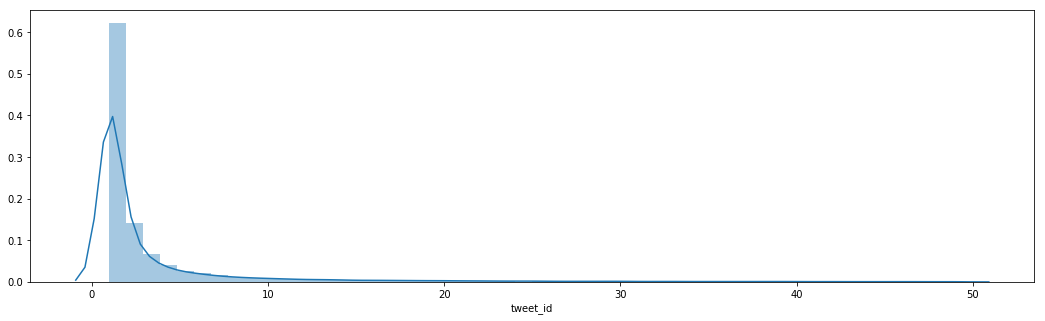

10682


In [7]:
users_tweets = df_tw.groupby('user_id').tweet_id.count().sort_values(ascending=False)
fig, ax = pyplot.subplots(figsize=(18,5))
sns.distplot(users_tweets[users_tweets<50])
pyplot.show()
print(len(users_tweets[users_tweets>=10])) # at least 10 tweets

In [166]:
selected_users = users_tweets[users_tweets>=5]
df = df_tw[df_tw.user_id.isin(selected_users.index.values)]
print(len(df))

1018646


In [167]:
#check there is no extra users
selected_users[~selected_users.index.isin(df_u.user_id.values)]

Series([], Name: tweet_id, dtype: int64)

## model

In [10]:
import tensorflow_addons as tfa
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
import tensorflow as tf
from tensorflow.python import keras

In [11]:
2**8

256

In [259]:
tw_len = 10
embed_dim = 100
residual_dim = 8

inputs = layers.Input(shape=(tw_len, embed_dim), name='input')

residual = layers.Dense(70, activation='elu')(inputs)
residual = layers.Dense(residual_dim, activation='linear')(residual)
residual = layers.BatchNormalization(axis=2)(residual)

res = False

for i in [70,30,20]:
    first_layer = i == 70
    x_0 = layers.Dense(i, activation='elu')(inputs if first_layer else x)
    x_1 = layers.Dense(i, activation='elu')(inputs if first_layer else x)
    x = keras.layers.concatenate([x_0,x_1], axis=1)
    x = layers.BatchNormalization(axis=2)(x)
    res_tmp = layers.Flatten()(layers.Dense(1, activation='elu')(x))
    if(first_layer):
        res = res_tmp
    else:
        res_tmp = keras.layers.concatenate([res, res_tmp])
        res = keras.layers.Dense(50, activation='elu')(res_tmp)
        res = layers.BatchNormalization()(res)
    x = layers.Dense(i*2, activation='elu')(x)
    x = layers.BatchNormalization(axis=2)(x)
    
x = layers.Flatten()(x)
for i in [1024, 512, 256]:
    x = layers.Dense(i, activation='elu')(x)
    if(i==1024):
        x = keras.layers.concatenate([x, res])
    x = layers.BatchNormalization()(x)

encoder_mu = layers.Dense(100, activation='linear', name='encoder_mu')(x)
encoder_log_var = layers.Dense(100, activation='linear', name='encoder_log_var')(x)

encoder = keras.Model(inputs=inputs, outputs=[encoder_mu, encoder_log_var, residual], name='encoder')

decoder_input = layers.Input(shape=100)
decoder_input_2 = layers.Input(shape=(tw_len, residual_dim))

x = tf.keras.backend.repeat(decoder_input, tw_len)
res = False

for i in range(5):
    first_layer = i == 0
    x_1 = layers.Dense(70, activation='elu')(x) #(None, 10, 50)
    x_2 = layers.Dense(40, activation='elu')(x) #(None, 10, 20)
    if(not first_layer):
        x_2 = keras.layers.concatenate([x_2, res], axis=2)
        x_2 = layers.Dense(40, activation='elu')(x_2)
    res = x_2
    x_3 = keras.layers.concatenate([layers.Dense(70, activation='elu')(x), decoder_input_2], axis=2) #(None, 10, 70)
    x = keras.layers.concatenate([x_1,x_2,x_3], axis=2)
    x = layers.BatchNormalization(axis=2)(x)
    
x = layers.Dense(200, activation='elu')(x)
x = layers.BatchNormalization(axis=2)(x)
decoded = layers.Dense(100, activation='linear')(x)

decoder = keras.Model([decoder_input, decoder_input_2], decoded, name="decoder")

In [153]:
display(encoder.summary())
display(decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10, 100)]    0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 10, 70)       7070        input[0][0]                      
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 10, 70)       7070        input[0][0]                      
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 20, 70)       0           dense_42[0][0]                   
                                                                 dense_43[0][0]             

None

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 100)]     0           input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Tile_1 (TensorFlowO [(None, 10, 100)]    0           tf_op_layer_ExpandDims_1[0][0]   
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 10, 70)       7070        tf_op_layer_Tile_1[0][0]         
____________________________________________________________________________________________

None

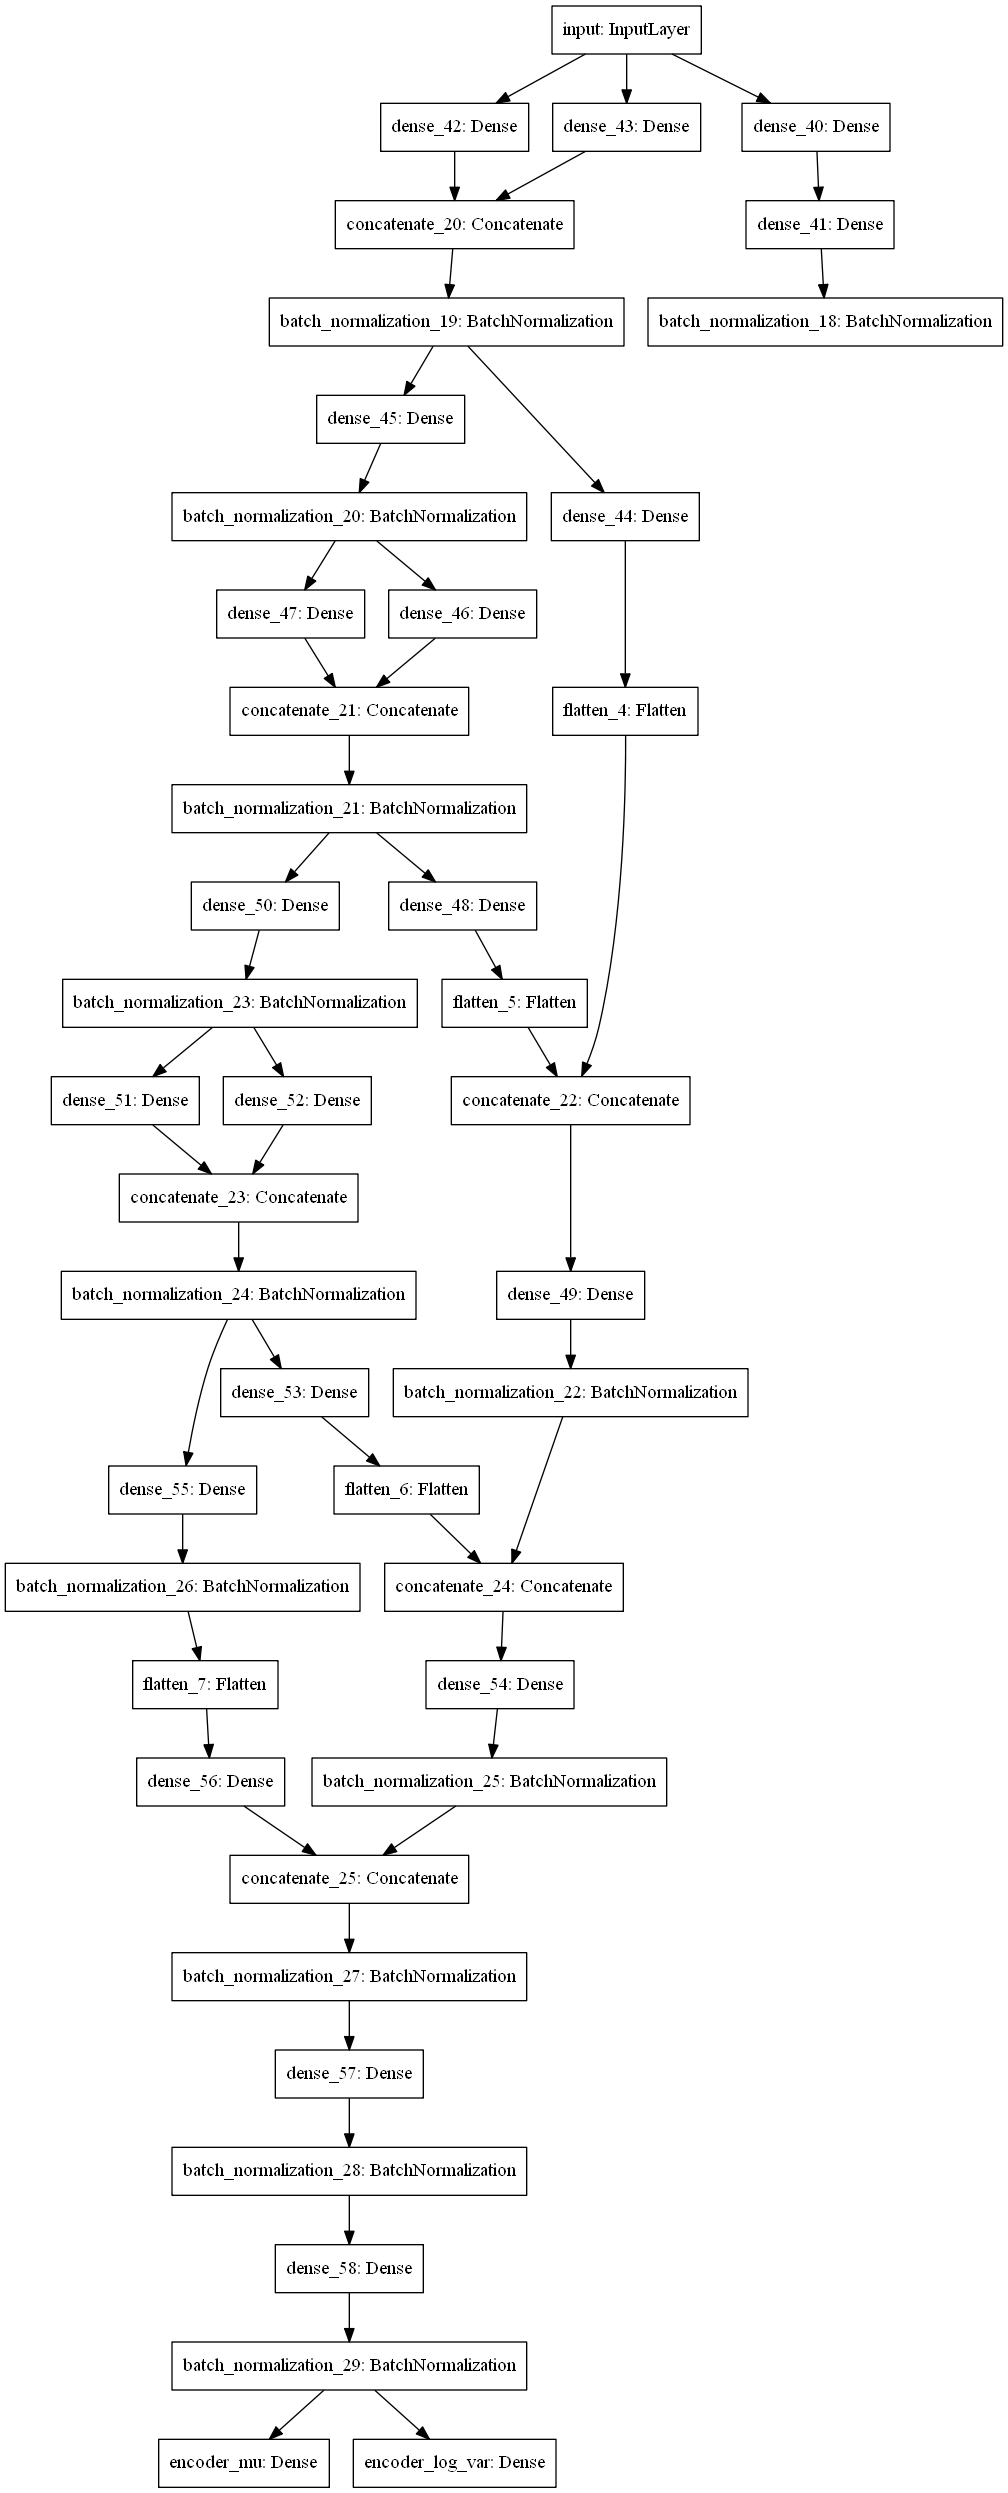

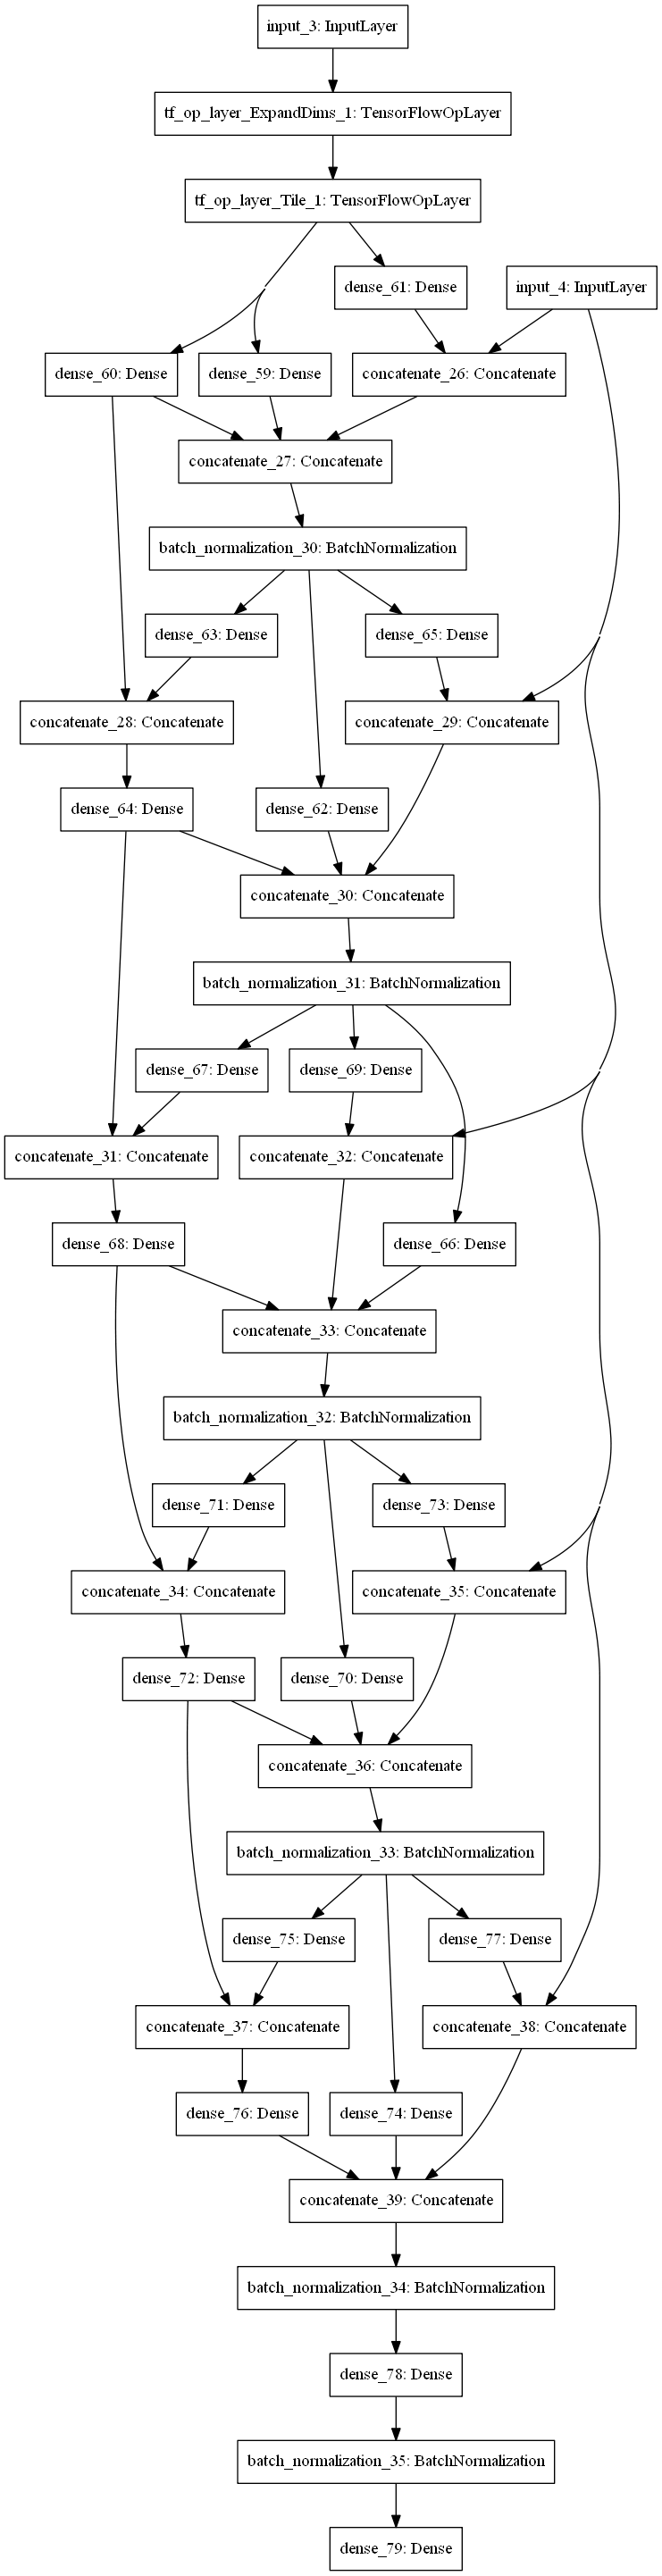

In [154]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.utils import plot_model
display(plot_model(encoder))
plot_model(decoder)

## generator

In [241]:
def data_generator(df, batch_size=100, num_tweets=10, dim=100):
    model = TW.TweetToVect()
    model.load_model(fast_text_model=word_model)
    while True:
        user_ids = np.random.choice(df.user_id.unique(), batch_size)
        tmp_df = df[df.user_id.isin(user_ids)]
        users = []
        for uid in user_ids:
            user_df = tmp_df[tmp_df.user_id==uid]
            if(len(user_df)<10):
                texts = user_df.sample(10, replace=True).full_text_cleaned.values
            else:
                min_start = len(user_df) - 10
                if(min_start==0):
                    start=0
                else:
                    start = np.random.randint(0, min_start)
                texts = user_df.full_text_cleaned.values[start:start+10]
            vectors = model.get_vectors(texts, True)
            users.append(vectors)
            
        users = np.array(users)
        yield users

gen_test = data_generator(df, 20)
next(gen_test).shape

(20, 10, 100)

## loss

In [284]:
def sampling(mu, log_var):
    z_mean, z_log_var = mu, log_var
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Pérdida de reconstrucción
def r_loss(y_true, encodings):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=2, reduction='none')
    loss = cosine_loss(y_true, encodings)
    loss = tf.keras.backend.mean(loss, axis=1)
    return loss


# Divergencia KL
def kl_loss(mu, log_var):
    kl_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    return kl_loss
#     return -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
#     return -0.5 * K.sum(1 + log_var - K.square(mu)- K.exp(log_var), axis = 1)


def vae_loss(encoder, decoder, input_tensor):
    
    mu, log_var, residual = encoder(input_tensor)
    encoded = sampling(mu, log_var)
    decoded = decoder([encoded, residual])
    
    r_l = r_loss(input_tensor, decoded) #loss reconstruccion
    k_l = kl_loss(mu, log_var)
    loss = (k_l*(r_l*-0.3)) + (r_l * 1000)
    return K.mean(loss), K.mean(r_l), K.mean(k_l)

# data_batch = next(gen_test)
vae_loss(encoder, decoder, data_batch)

(<tf.Tensor: shape=(), dtype=float32, numpy=-843.73004>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8439704>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.949101>)

## save

In [316]:
def save_autoencoder(encoder, decoder, model_dir):
    model_json = encoder.to_json()
    with open(model_dir+"user_to_vect_encoder_b.json", "w") as json_file:
        json_file.write(model_json)
    encoder.save_weights(model_dir+"user_to_vect_encoder_b.h5")
    
    model_json = decoder.to_json()
    with open(model_dir+"user_to_vect_decoder_b.json", "w") as json_file:
        json_file.write(model_json)
    decoder.save_weights(model_dir+"user_to_vect_decoder_b.h5")
    return True

save_autoencoder(encoder, decoder, model_dir)

True

## fit

In [231]:
2**7

128

In [312]:
epochs = 100
steps = 20
batch_size = 2**7
model_dir = '../models/'
# history = []

generator = data_generator(df, batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

for e in range(epochs):
    for s in range(steps):
        with tf.GradientTape() as tape:
            data_batch = next(generator)
            loss, r_l, k_l = vae_loss(encoder, decoder, data_batch)
            
        sys.stdout.write(f'\rEpoch {e+1}: step {s+1}/{steps} \t loss {round(float(loss), 2)} \t r_loss {round(float(r_l), 3)} \t k_l {round(float(k_l), 3)}')
        sys.stdout.flush()
            
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        grads = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(grads, trainable_variables))
        if(s+1==steps):
            print('')
            history.append(loss)
            try:
                save_autoencoder(encoder, decoder, model_dir)
            except:
                print('ERROR ON SAVE')

Epoch 1: step 1/20 	 loss -884.45 	 r_loss -0.885 	 k_l 2.181

W0804 04:07:37.974661  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:07:37.975662  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:07:37.975662  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 1: step 20/20 	 loss -879.87 	 r_loss -0.88 	 k_l 2.213
Epoch 2: step 20/20 	 loss -885.52 	 r_loss -0.886 	 k_l 2.198
Epoch 3: step 18/20 	 loss -886.33 	 r_loss -0.887 	 k_l 2.154

W0804 04:12:09.856487  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 3: step 20/20 	 loss -887.6 	 r_loss -0.888 	 k_l 2.184
Epoch 4: step 20/20 	 loss -888.67 	 r_loss -0.889 	 k_l 2.277
Epoch 5: step 17/20 	 loss -897.52 	 r_loss -0.898 	 k_l 2.364

W0804 04:15:18.727176  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 5: step 20/20 	 loss -888.16 	 r_loss -0.889 	 k_l 2.294
Epoch 6: step 12/20 	 loss -889.23 	 r_loss -0.89 	 k_l 2.291

W0804 04:16:27.512640  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 6: step 20/20 	 loss -893.88 	 r_loss -0.895 	 k_l 2.306
Epoch 7: step 20/20 	 loss -891.4 	 r_loss -0.892 	 k_l 2.369
Epoch 8: step 10/20 	 loss -894.5 	 r_loss -0.895 	 k_l 2.377

W0804 04:19:30.859501  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 8: step 14/20 	 loss -897.49 	 r_loss -0.898 	 k_l 2.374

W0804 04:19:46.794463  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 8: step 20/20 	 loss -894.44 	 r_loss -0.895 	 k_l 2.462
Epoch 9: step 20/20 	 loss -896.84 	 r_loss -0.897 	 k_l 2.436
Epoch 10: step 9/20 	 loss -898.4 	 r_loss -0.899 	 k_l 2.427

W0804 04:22:38.279770  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:22:38.280738  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 10: step 20/20 	 loss -897.7 	 r_loss -0.898 	 k_l 2.47
Epoch 11: step 20/20 	 loss -897.64 	 r_loss -0.898 	 k_l 2.521
Epoch 12: step 14/20 	 loss -897.64 	 r_loss -0.898 	 k_l 2.503

W0804 04:26:09.995069  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:26:09.996069  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:26:09.996069  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 12: step 20/20 	 loss -898.92 	 r_loss -0.9 	 k_l 2.51
Epoch 13: step 20/20 	 loss -896.99 	 r_loss -0.898 	 k_l 2.509
Epoch 14: step 20/20 	 loss -900.6 	 r_loss -0.901 	 k_l 2.536
Epoch 15: step 20/20 	 loss -902.64 	 r_loss -0.903 	 k_l 2.554
Epoch 16: step 10/20 	 loss -898.16 	 r_loss -0.899 	 k_l 2.591

W0804 04:32:18.387892  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 16: step 20/20 	 loss -898.99 	 r_loss -0.9 	 k_l 2.532
Epoch 17: step 5/20 	 loss -897.11 	 r_loss -0.898 	 k_l 2.604

W0804 04:33:26.291602  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:33:26.292602  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:33:26.293602  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 17: step 20/20 	 loss -900.34 	 r_loss -0.901 	 k_l 2.611
Epoch 18: step 20/20 	 loss -903.1 	 r_loss -0.904 	 k_l 2.569
Epoch 19: step 20/20 	 loss -902.37 	 r_loss -0.903 	 k_l 2.675
Epoch 20: step 18/20 	 loss -901.03 	 r_loss -0.902 	 k_l 2.658

W0804 04:39:13.545338  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:39:13.546338  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:39:13.547338  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 20: step 20/20 	 loss -905.76 	 r_loss -0.906 	 k_l 2.692
Epoch 21: step 15/20 	 loss -902.26 	 r_loss -0.903 	 k_l 2.682

W0804 04:40:38.720523  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:40:38.721522  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 21: step 19/20 	 loss -900.7 	 r_loss -0.901 	 k_l 2.607

W0804 04:40:55.174037  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 04:40:55.174037  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 21: step 20/20 	 loss -902.12 	 r_loss -0.903 	 k_l 2.582
Epoch 22: step 2/20 	 loss -900.79 	 r_loss -0.902 	 k_l 2.617

W0804 04:41:11.715221  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 22: step 5/20 	 loss -898.72 	 r_loss -0.899 	 k_l 2.61

W0804 04:41:26.706835  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 22: step 20/20 	 loss -901.06 	 r_loss -0.902 	 k_l 2.625
Epoch 23: step 20/20 	 loss -904.72 	 r_loss -0.905 	 k_l 2.702
Epoch 24: step 3/20 	 loss -906.67 	 r_loss -0.907 	 k_l 2.694

W0804 04:44:25.045848  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 24: step 20/20 	 loss -907.07 	 r_loss -0.908 	 k_l 2.787
Epoch 25: step 20/20 	 loss -904.37 	 r_loss -0.905 	 k_l 2.715
Epoch 26: step 15/20 	 loss -903.38 	 r_loss -0.904 	 k_l 2.781

W0804 04:48:37.999482  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 26: step 20/20 	 loss -906.18 	 r_loss -0.907 	 k_l 2.741
Epoch 27: step 20/20 	 loss -902.87 	 r_loss -0.904 	 k_l 2.774
Epoch 28: step 20/20 	 loss -904.4 	 r_loss -0.905 	 k_l 2.744
Epoch 29: step 20/20 	 loss -905.11 	 r_loss -0.906 	 k_l 2.806
Epoch 30: step 4/20 	 loss -902.37 	 r_loss -0.903 	 k_l 2.754

W0804 04:54:16.858026  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 30: step 13/20 	 loss -910.35 	 r_loss -0.911 	 k_l 2.758

W0804 04:54:57.418723  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 30: step 20/20 	 loss -901.9 	 r_loss -0.903 	 k_l 2.819
Epoch 31: step 20/20 	 loss -906.29 	 r_loss -0.907 	 k_l 2.731
Epoch 32: step 20/20 	 loss -906.8 	 r_loss -0.908 	 k_l 2.766
Epoch 33: step 20/20 	 loss -900.06 	 r_loss -0.901 	 k_l 2.815
Epoch 34: step 7/20 	 loss -907.73 	 r_loss -0.909 	 k_l 2.883

W0804 05:00:50.572224  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 34: step 20/20 	 loss -909.18 	 r_loss -0.91 	 k_l 2.829
Epoch 35: step 20/20 	 loss -906.64 	 r_loss -0.907 	 k_l 2.817
Epoch 36: step 20/20 	 loss -908.45 	 r_loss -0.909 	 k_l 2.89
Epoch 37: step 20/20 	 loss -907.86 	 r_loss -0.909 	 k_l 2.767
Epoch 38: step 18/20 	 loss -904.7 	 r_loss -0.905 	 k_l 2.866

W0804 05:08:03.464646  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 38: step 20/20 	 loss -909.58 	 r_loss -0.91 	 k_l 2.858
Epoch 39: step 20/20 	 loss -912.02 	 r_loss -0.913 	 k_l 2.85
Epoch 40: step 1/20 	 loss -914.43 	 r_loss -0.915 	 k_l 2.839

W0804 05:09:57.363032  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 40: step 20/20 	 loss -910.04 	 r_loss -0.911 	 k_l 2.896
Epoch 41: step 20/20 	 loss -904.96 	 r_loss -0.906 	 k_l 2.895
Epoch 42: step 20/20 	 loss -908.94 	 r_loss -0.91 	 k_l 2.911
Epoch 43: step 20/20 	 loss -906.51 	 r_loss -0.907 	 k_l 2.873
Epoch 44: step 20/20 	 loss -908.48 	 r_loss -0.909 	 k_l 2.866
Epoch 45: step 20/20 	 loss -913.43 	 r_loss -0.914 	 k_l 2.879
Epoch 46: step 20/20 	 loss -911.3 	 r_loss -0.912 	 k_l 2.967
Epoch 47: step 20/20 	 loss -913.31 	 r_loss -0.914 	 k_l 2.926
Epoch 48: step 20/20 	 loss -913.74 	 r_loss -0.915 	 k_l 2.943
Epoch 49: step 20/20 	 loss -910.09 	 r_loss -0.911 	 k_l 2.96
Epoch 50: step 10/20 	 loss -911.52 	 r_loss -0.912 	 k_l 2.932

W0804 05:26:31.167621  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 50: step 20/20 	 loss -914.81 	 r_loss -0.916 	 k_l 2.98
Epoch 51: step 11/20 	 loss -913.02 	 r_loss -0.914 	 k_l 2.975

W0804 05:28:13.586406  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 51: step 20/20 	 loss -912.57 	 r_loss -0.913 	 k_l 2.943
Epoch 52: step 4/20 	 loss -913.38 	 r_loss -0.914 	 k_l 2.977

W0804 05:29:15.891559  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 52: step 12/20 	 loss -911.08 	 r_loss -0.912 	 k_l 2.947

W0804 05:29:51.176157  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 52: step 20/20 	 loss -912.2 	 r_loss -0.913 	 k_l 3.007
Epoch 53: step 20/20 	 loss -912.58 	 r_loss -0.913 	 k_l 2.959


W0804 05:32:15.738771  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 54: step 3/20 	 loss -912.94 	 r_loss -0.914 	 k_l 2.885

W0804 05:32:28.051770  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:32:28.052770  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 54: step 17/20 	 loss -911.36 	 r_loss -0.912 	 k_l 2.928

W0804 05:33:34.553162  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 54: step 20/20 	 loss -916.78 	 r_loss -0.918 	 k_l 2.971
Epoch 55: step 20/20 	 loss -910.69 	 r_loss -0.911 	 k_l 2.943
Epoch 56: step 20/20 	 loss -910.55 	 r_loss -0.911 	 k_l 2.943
Epoch 57: step 2/20 	 loss -908.67 	 r_loss -0.909 	 k_l 2.962

W0804 05:37:07.390733  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 57: step 20/20 	 loss -910.42 	 r_loss -0.911 	 k_l 2.968
Epoch 58: step 3/20 	 loss -908.95 	 r_loss -0.91 	 k_l 2.877

W0804 05:38:47.341179  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 58: step 20/20 	 loss -915.37 	 r_loss -0.916 	 k_l 2.935
Epoch 59: step 20/20 	 loss -910.48 	 r_loss -0.911 	 k_l 2.941
Epoch 60: step 20/20 	 loss -911.75 	 r_loss -0.913 	 k_l 3.003
Epoch 61: step 20/20 	 loss -914.74 	 r_loss -0.916 	 k_l 3.007
Epoch 62: step 8/20 	 loss -908.67 	 r_loss -0.909 	 k_l 2.959

W0804 05:45:27.789387  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:45:27.848405  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 62: step 14/20 	 loss -912.82 	 r_loss -0.914 	 k_l 2.952

W0804 05:45:56.380410  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 62: step 19/20 	 loss -912.08 	 r_loss -0.913 	 k_l 2.958

W0804 05:46:19.835901  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 62: step 20/20 	 loss -914.0 	 r_loss -0.915 	 k_l 2.974
Epoch 63: step 20/20 	 loss -914.18 	 r_loss -0.915 	 k_l 2.981
Epoch 64: step 20/20 	 loss -911.45 	 r_loss -0.912 	 k_l 2.942
Epoch 65: step 10/20 	 loss -914.36 	 r_loss -0.915 	 k_l 2.969

W0804 05:50:25.065222  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 65: step 20/20 	 loss -914.21 	 r_loss -0.915 	 k_l 3.016
Epoch 66: step 3/20 	 loss -916.1 	 r_loss -0.917 	 k_l 3.001

W0804 05:51:27.107997  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:51:27.108996  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:51:27.109998  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:51:27.109998  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 66: step 20/20 	 loss -913.78 	 r_loss -0.915 	 k_l 2.897
Epoch 67: step 15/20 	 loss -912.91 	 r_loss -0.914 	 k_l 3.013

W0804 05:54:06.277009  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 67: step 18/20 	 loss -913.23 	 r_loss -0.914 	 k_l 3.025

W0804 05:54:19.223903  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:19.224903  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:19.225902  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:19.226902  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:19.227909  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 67: step 19/20 	 loss -911.04 	 r_loss -0.912 	 k_l 3.02

W0804 05:54:26.620122  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:26.621096  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:54:26.621096  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 67: step 20/20 	 loss -906.23 	 r_loss -0.907 	 k_l 2.985
Epoch 68: step 20/20 	 loss -914.19 	 r_loss -0.915 	 k_l 2.999
Epoch 69: step 20/20 	 loss -911.18 	 r_loss -0.912 	 k_l 2.954


W0804 05:57:41.709859  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:57:41.709859  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 05:57:41.710864  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 70: step 20/20 	 loss -912.08 	 r_loss -0.913 	 k_l 3.024
Epoch 71: step 11/20 	 loss -913.17 	 r_loss -0.914 	 k_l 2.993

W0804 06:00:09.358561  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 71: step 12/20 	 loss -915.19 	 r_loss -0.916 	 k_l 2.956

W0804 06:00:13.759587  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:00:13.760592  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:00:13.760592  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:00:13.761575  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 71: step 20/20 	 loss -911.86 	 r_loss -0.913 	 k_l 3.004
Epoch 72: step 4/20 	 loss -916.02 	 r_loss -0.917 	 k_l 3.032

W0804 06:01:14.738389  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 72: step 20/20 	 loss -913.89 	 r_loss -0.915 	 k_l 2.956
Epoch 73: step 20/20 	 loss -916.42 	 r_loss -0.917 	 k_l 3.008
Epoch 74: step 2/20 	 loss -910.56 	 r_loss -0.911 	 k_l 3.005

W0804 06:04:17.979431  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 74: step 18/20 	 loss -914.46 	 r_loss -0.915 	 k_l 3.029

W0804 06:05:41.416295  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 74: step 20/20 	 loss -912.43 	 r_loss -0.913 	 k_l 3.023
Epoch 75: step 8/20 	 loss -911.53 	 r_loss -0.912 	 k_l 2.95

W0804 06:06:28.028479  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 75: step 9/20 	 loss -912.86 	 r_loss -0.914 	 k_l 2.946

W0804 06:06:30.297505  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 75: step 20/20 	 loss -915.5 	 r_loss -0.916 	 k_l 2.995
Epoch 76: step 20/20 	 loss -912.74 	 r_loss -0.914 	 k_l 3.003
Epoch 77: step 20/20 	 loss -916.23 	 r_loss -0.917 	 k_l 2.977
Epoch 78: step 5/20 	 loss -913.6 	 r_loss -0.914 	 k_l 2.99

W0804 06:11:02.309452  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 78: step 20/20 	 loss -913.29 	 r_loss -0.914 	 k_l 2.952
Epoch 79: step 20/20 	 loss -911.33 	 r_loss -0.912 	 k_l 2.973
Epoch 80: step 3/20 	 loss -911.22 	 r_loss -0.912 	 k_l 3.026

W0804 06:14:08.718344  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 80: step 20/20 	 loss -915.28 	 r_loss -0.916 	 k_l 3.0
Epoch 81: step 20/20 	 loss -913.38 	 r_loss -0.914 	 k_l 2.983
Epoch 82: step 3/20 	 loss -915.07 	 r_loss -0.916 	 k_l 2.967

W0804 06:17:16.533488  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 82: step 9/20 	 loss -915.64 	 r_loss -0.916 	 k_l 2.987

W0804 06:17:42.894149  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 82: step 14/20 	 loss -918.03 	 r_loss -0.919 	 k_l 2.988

W0804 06:18:04.188989  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:18:04.189957  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:18:04.189957  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:18:04.190956  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 82: step 18/20 	 loss -916.61 	 r_loss -0.917 	 k_l 2.979

W0804 06:18:23.179985  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 82: step 20/20 	 loss -917.51 	 r_loss -0.918 	 k_l 3.012
Epoch 83: step 20/20 	 loss -915.56 	 r_loss -0.916 	 k_l 3.004
Epoch 84: step 14/20 	 loss -912.94 	 r_loss -0.914 	 k_l 2.98

W0804 06:21:19.281107  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:21:19.281107  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 84: step 20/20 	 loss -915.33 	 r_loss -0.916 	 k_l 3.022
Epoch 85: step 7/20 	 loss -914.52 	 r_loss -0.915 	 k_l 2.959

W0804 06:22:20.947388  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 85: step 11/20 	 loss -912.66 	 r_loss -0.913 	 k_l 2.94

W0804 06:22:41.396309  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 85: step 20/20 	 loss -911.08 	 r_loss -0.912 	 k_l 3.04
Epoch 86: step 20/20 	 loss -912.42 	 r_loss -0.913 	 k_l 2.97
Epoch 87: step 7/20 	 loss -912.72 	 r_loss -0.914 	 k_l 2.995

W0804 06:25:30.446438  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:25:30.447438  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 87: step 8/20 	 loss -911.76 	 r_loss -0.913 	 k_l 2.997

W0804 06:25:33.295439  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:25:33.295439  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 87: step 20/20 	 loss -909.52 	 r_loss -0.91 	 k_l 2.981
Epoch 88: step 20/20 	 loss -917.27 	 r_loss -0.918 	 k_l 2.985
Epoch 89: step 20/20 	 loss -913.22 	 r_loss -0.914 	 k_l 2.992
Epoch 90: step 20/20 	 loss -916.4 	 r_loss -0.917 	 k_l 3.017
Epoch 91: step 20/20 	 loss -914.85 	 r_loss -0.916 	 k_l 3.036
Epoch 92: step 7/20 	 loss -915.9 	 r_loss -0.917 	 k_l 3.017

W0804 06:33:25.647589  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 92: step 20/20 	 loss -910.83 	 r_loss -0.912 	 k_l 2.964
Epoch 93: step 7/20 	 loss -916.68 	 r_loss -0.918 	 k_l 3.053

W0804 06:34:57.050444  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 93: step 20/20 	 loss -919.98 	 r_loss -0.921 	 k_l 2.99
Epoch 94: step 20/20 	 loss -910.98 	 r_loss -0.912 	 k_l 3.077
Epoch 95: step 11/20 	 loss -914.29 	 r_loss -0.915 	 k_l 3.008

W0804 06:38:26.161277  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 95: step 20/20 	 loss -915.11 	 r_loss -0.916 	 k_l 3.013
Epoch 96: step 20/20 	 loss -916.96 	 r_loss -0.918 	 k_l 3.041
Epoch 97: step 20/20 	 loss -916.27 	 r_loss -0.917 	 k_l 2.973
Epoch 98: step 5/20 	 loss -918.78 	 r_loss -0.92 	 k_l 2.965

W0804 06:42:45.669594  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 98: step 20/20 	 loss -913.93 	 r_loss -0.915 	 k_l 3.054
Epoch 99: step 4/20 	 loss -919.92 	 r_loss -0.921 	 k_l 2.998

W0804 06:44:16.105319  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 99: step 9/20 	 loss -920.19 	 r_loss -0.921 	 k_l 2.995

W0804 06:44:38.508251  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:44:38.509218  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 99: step 18/20 	 loss -915.03 	 r_loss -0.916 	 k_l 3.035

W0804 06:45:19.117154  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:45:19.118154  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector
W0804 06:45:19.118154  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 99: step 20/20 	 loss -917.03 	 r_loss -0.918 	 k_l 2.999
Epoch 100: step 2/20 	 loss -913.38 	 r_loss -0.914 	 k_l 2.982

W0804 06:45:40.985010  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 100: step 4/20 	 loss -912.6 	 r_loss -0.913 	 k_l 2.975

W0804 06:45:50.546010  2848 keyedvectors.py:2140] could not extract any ngrams from '', returning origin vector


Epoch 100: step 20/20 	 loss -913.93 	 r_loss -0.915 	 k_l 3.063


## test model

In [307]:
to_compare_df = df_u[df_u.user_name.isin(['alferdez','Kicillofok','SilContini','Marafer23701816','KikeMasllorens','omar_panart','proargentina','JulioDeVido','FMetaza','Norma20191','MAbolicion','PGimenezDC''monfortmarcelo','bombo787','PrismaMov','RubenhMarin','MujeresCFKChaco','PRO_Mujeres','diputadosucr', 'JPROConcordia1'])]
# to_compare_df = df_u[df_u.user_name.isin(['alferdez','Kicillofok','Marafer23701816','KikeMasllorens','proargentina','JulioDeVido','PGimenezDC''monfortmarcelo','bombo787','PrismaMov'])]

#filtro los usuarios de aca que no tengan mas de 3 tweets
filtrados = to_compare_df[(to_compare_df.user_id.isin(users_tweets[users_tweets>3].index.values))==False].user_name.values
to_compare_df = to_compare_df[to_compare_df.user_id.isin(users_tweets[users_tweets>3].index.values)]
print(users_tweets[to_compare_df.user_id])
print('pocos tweets:', filtrados)
to_compare_df

user_id
1055919539739938816      57
1066770503115988992     214
1103628302491754496      40
1114172164612268032      13
1234856938971766785     105
126418051               209
149991703              1351
18143118                598
196340158               300
250297107               467
2952640125               53
2953955753             1512
36152999                 11
4906419622               72
768068458848382976      102
987454440549568512       11
Name: tweet_id, dtype: int64
pocos tweets: ['Marafer23701816']


,user_id,user_name,name,description,url,created_at,geo_enabled,verified,profile_image_url,profile_image_url_large,...,friends_count,listed_count,favourites_count,statuses_count,media_count,pinned_tweet,tweets_scraped,tweets_scraped_at,scrapped_at,ignore
4750,1055919539739938816,RubenhMarin,Rubén Marin,✌Pte. del PJ Pampeano ✌Coordinador de la mesa de acción política del PJ Nacional. ✌4 veces gober...,NaN,2018-10-26 20:30:11.0,1,0,https://pbs.twimg.com/profile_images/1192395305154699264/aPjaHRtD_normal.jpg,https://pbs.twimg.com/profile_images/1192395305154699264/aPjaHRtD_400x400.jpg,...,267,4,306,93,31,NaN,1,2020-07-28 03:01:15.0,2020-07-28 02:17:01.0,0
5547,1066770503115988992,MAbolicion,Mujeres por la abolición,"Somos feministas radicales. Abolicionistas del género, prostitución, pornografía y vientres de a...",https://t.co/ua6mr4ysRM,2018-11-25 19:08:02.0,0,0,https://pbs.twimg.com/profile_images/1268640645645774850/6SzMcljs_normal.jpg,https://pbs.twimg.com/profile_images/1268640645645774850/6SzMcljs_400x400.jpg,...,845,39,6163,15089,2205,1.279824e+18,1,2020-07-28 04:12:27.0,2020-07-28 03:51:34.0,0
8689,1103628302491754496,Norma20191,Norma2019,"Mamá, Ingeniera Industrial, docente y peronista✌ Candidata a Intendente de Esquel #tiempodemujeres",NaN,2019-03-07 12:07:46.0,0,0,https://pbs.twimg.com/profile_images/1126126960260861958/rHer4Yli_normal.jpg,https://pbs.twimg.com/profile_images/1126126960260861958/rHer4Yli_400x400.jpg,...,109,0,22,107,27,NaN,1,2020-07-28 14:33:22.0,2020-07-28 02:17:57.0,0
9696,1114172164612268032,MujeresCFKChaco,Mujeres Peronistas con Cristina - Chaco,Espacio político trasversal donde Mujeres Peronistas reconocen el liderazgo de CFK en el proyect...,NaN,2019-04-05 14:25:19.0,0,0,https://pbs.twimg.com/profile_images/1114172494196375553/YDSQft7M_normal.jpg,https://pbs.twimg.com/profile_images/1114172494196375553/YDSQft7M_400x400.jpg,...,246,0,43,123,31,NaN,1,2020-07-28 16:12:44.0,2020-07-28 02:19:29.0,0
20697,1234856938971766785,FMetaza,Franco Metaza,Peronista kirchnerista✌🏻. Fundamentalista de la democracia 🗳. Politólogo 🌎. Director de Relacion...,https://t.co/kB6HoE4sGg,2020-03-03 15:03:43.0,0,0,https://pbs.twimg.com/profile_images/1266583748348391425/SzDaxPRk_normal.jpg,https://pbs.twimg.com/profile_images/1266583748348391425/SzDaxPRk_400x400.jpg,...,895,0,1832,291,44,1.240696e+18,1,2020-07-28 04:29:12.0,2020-07-28 02:18:32.0,0
24697,126418051,PRO_Mujeres,PRO Mujeres,"PRO Mujeres: más mujeres, mejor política. Buscamos incrementar la participación política de las ...",https://t.co/qNRlpKjmzF,2010-03-25 20:26:09.0,1,0,https://pbs.twimg.com/profile_images/984510589602074624/7bBIrJNG_normal.jpg,https://pbs.twimg.com/profile_images/984510589602074624/7bBIrJNG_400x400.jpg,...,861,100,3630,2891,685,NaN,1,2020-07-28 18:28:18.0,2020-07-28 02:20:47.0,0
34654,149991703,alferdez,Alberto Fernández,Abogado. Profesor de Derecho Penal (UBA). Hincha de Argentinos Juniors. Presidente de la Nación ...,https://t.co/1FuikS9nVQ,2010-05-30 19:38:40.0,0,1,https://pbs.twimg.com/profile_images/1192149786503327744/l232oveZ_normal.jpg,https://pbs.twimg.com/profile_images/1192149786503327744/l232oveZ_400x400.jpg,...,7286,1414,6760,26608,1703,NaN,1,2020-07-28 02:15:29.0,2020-07-28 02:12:16.0,0
44417,18143118,proargentina,PRO,Canal oficial de Twitter de PRO (Propuesta Republicana). Partido que lidera @mauriciomacri.,https://t.co/zyYm9UklqI,2008-12-15 18:54:05.0,1,1,https://pbs.twimg.com/profile_images/1246544306262990851/JkR82MLH_normal.jpg,https://pbs.twimg.com/profile_images/1246544306262990851/JkR82MLH_400x400.jpg,...,362,717,562,25445,3316,NaN,1,2020-07-28 11:18:24.0,2020-07-28 02:12:22.0,0
48036,196340158,JulioDeVido,Julio De Vido,Ministro de Planificación Federal de Néstor y Cristina Kirchner. Perseguido por el régimen macri...,NaN,2010-09-28 22:16:00.0,0,1,https://pbs.twimg.com/profile_images/517046223358808064/UaSdZ6qc_normal.jpeg,https://pbs.twimg.com/profile_images/517046223358808064/UaSdZ6qc_400x400.jpeg,...,94,304,402,207

In [313]:
to_compare_ids = to_compare_df.user_id.values
users = []
model = TW.TweetToVect()
model.load_model(fast_text_model=word_model)
for uid in to_compare_ids:
    user_df = df_tw[df_tw.user_id==uid]
    if(len(user_df)<10):
        texts = user_df.sample(10, replace=True).full_text_cleaned.values
    else:
        texts = user_df.full_text_cleaned.values[0:10]
    vectors = model.get_vectors(texts)
    users.append(vectors)
print(np.array(users).shape)
mu, log_var, residual = encoder(np.array(users))
encoded_users = sampling(mu, log_var)

(16, 10, 100)


In [314]:
encoded_users[0]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 6.33128345e-01, -2.04094261e-01, -3.98684204e-01,  5.29603101e-02,
        2.55172141e-04, -2.30583832e-01,  4.23170805e-01,  3.63176733e-01,
        6.15513682e-01,  8.57332170e-01,  3.26960653e-01, -3.91459882e-01,
       -2.90126532e-01,  3.08556557e-01,  1.50394112e-01,  3.76503319e-02,
       -3.44012886e-01,  6.19749784e-01, -5.97349823e-01,  1.14319727e-01,
       -6.48080647e-01, -6.70617446e-02, -3.83609802e-01,  3.11987221e-01,
       -2.29898825e-01,  5.64880490e-01,  3.92296851e-01, -4.52058874e-02,
        3.04304153e-01, -1.15979999e-01,  4.45723347e-02,  4.00973052e-01,
       -4.06385750e-01, -2.40583748e-01, -1.58435643e-01, -4.83796448e-02,
        6.91999316e-01,  8.88134539e-03, -5.07317960e-01,  5.35537675e-02,
        3.38888526e-01, -2.59946585e-01, -5.19727096e-02,  4.55627620e-01,
        2.28318542e-01, -2.52388492e-02, -5.15986860e-01, -1.37858987e-01,
        3.20176721e-01,  1.30970284e-01, -1.95762128

In [315]:
for i in range(len(encoded_users)):
    similarities = model.pairwise_similarity_vectors([encoded_users[i]], encoded_users)
    similarity_index = np.argsort(similarities[0])[::-1]
    similarity_sorted = np.sort(similarities[0])[::-1]
#     display(to_compare_df.iloc[similarity_index])
    print(to_compare_df.name.values[i], to_compare_df.description.values[i].replace('\n',' '))
    print('SIMILAR A')
    similar_df = to_compare_df.iloc[similarity_index]
    print(round(similarity_sorted[1],2), similar_df.name.values[1], similar_df.description.values[1].replace('\n',' '))
    print(round(similarity_sorted[2],2), similar_df.name.values[2], similar_df.description.values[2].replace('\n',' '))
    print(round(similarity_sorted[3],2), similar_df.name.values[3], similar_df.description.values[3].replace('\n',' '))
    print('---')

Rubén Marin ✌Pte. del PJ Pampeano ✌Coordinador de la mesa de acción política del PJ Nacional. ✌4 veces gobernador de mi provincia. ✌Siempre del lado de la unidad nacional.
SIMILAR A
0.53 Julio De Vido Ministro de Planificación Federal de Néstor y Cristina Kirchner. Perseguido por el régimen macrista. Militante peronista. Libertad a los presos políticos.
0.47 Alberto Fernández Abogado. Profesor de Derecho Penal (UBA). Hincha de Argentinos Juniors. Presidente de la Nación Argentina.
0.41 Mujeres Peronistas con Cristina - Chaco Espacio político trasversal donde Mujeres Peronistas reconocen el liderazgo de CFK en el proyecto nacional, popular, democrático y feminista.
---
Mujeres por la abolición Somos feministas radicales. Abolicionistas del género, prostitución, pornografía y vientres de alquiler. Promovemos acciones para acabar con el patriarcado.
SIMILAR A
0.59 Mujeres Peronistas con Cristina - Chaco Espacio político trasversal donde Mujeres Peronistas reconocen el liderazgo de CFK en 

In [311]:
pd.options.display.max_colwidth = 100
df_u[(df_u.description.str.contains('PRO')==True) & (df_u.tweets_scraped==1)][['user_name', 'name', 'description', 'friends_count']].sort_values('friends_count', ascending=False)

,user_name,name,description,friends_count
57919,eljugenio,EL INTERIOR PROFUNDO 😺,JUJEÑO VIVIENDO EN EL SUDESTE CORDOBÉS /HOMBRE DEL DERECHO/SIGO LA COHERENCIA/VALORES MORALES/PR...,8708
119870,ChauOperetaK,EL ANTI OPERETA,"Blanco👱‍♂️, Anti K 🇦🇷, anti Maduro 🇻🇪, anti Evo 🇬🇭, anti planeros✌🏿, anti feministas violentas 💅...",7592
32771,Horaciogenta,Horacio Genta,"Divorciado y solo !!,pisciano,optimista con este gobierno del PRO,me seguis ? te sigo !! nunca v...",4709
39348,laurmachado,Laura Rodríguez Machado,Abogada. Senadora Nacional (2015-2021). Vicepresidente segunda del PRO Nacional. Vicepresidente ...,4216
84933,FlorDittrich,Florencia Dittrich,🇦🇷💙💙 entre Buenos Aires y San Francisco #Córdoba 🎼 melómana 📚 MBA @UCEMA_edu Lic.en Adm @Economi...,4057
45851,elkotur,jorge rachid,MEDICO DE BARRIO Y DEL TRABAJO-MILITANTE PERONISTA-PROFESOR EN LA SOCIALES EN UNLZ-ESCRITOR-PRES...,3686
32317,MLVarela,Marta Varela,Sigo pensando en una Argentina con futuro. PRO. Facebook/MartaVarela15 https://t.co/9Y42PBrNkH,3684
51001,oscar_orion,OSCAR A. RODRIGUEZ,"HE NACIDO, HE CRECIDO Y ME HE REPRODUCIDO, CREO QUE NO ES POCO VERDAD?",3235
109145,Elvio_bono,Cordobes Macrista💙,Cordobes Macrista del 61% Hincha de River y afiliado al PRO. A la derecha de la derecha siempre...,3182
62750,silvinafrana,Silvina Frana,"Justicialista. Trabajadora. Contadora. Esposa, madre y abuela. \nMINISTRA DE INFRAESTRUCTURA, SE...",2219
